# WaveNet

* `Wavenet: A generative model for raw audio`, [arXiv:1609.03499](https://arxiv.org/abs/1609.03499)
  * Aa ̈ron van den Oord, Sander Dieleman, Heiga Zen, Karen Simonyan, Oriol Vinyals, Alex Graves, Nal Kalchbrenner, Andrew Senior, and Koray Kavukcuoglu

* This code is available to tensorflow version 2.0
* Implemented by [`tf.keras.layers`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers) and [`tf.losses`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/losses)

## Import modules

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
import imageio
from IPython import display

import librosa
import librosa.display

import tensorflow as tf
from tensorflow.keras import layers

sys.path.append(os.path.dirname(os.path.abspath('.')))
from utils.image_utils import *
from utils.ops import *

os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages

## Setting hyperparameters

In [6]:
# Training Flags (hyperparameter configuration)
model_name = 'wavenet'
train_dir = os.path.join('train', model_name, 'exp1')
dataset_name = 'toy_data'
assert dataset_name in ['toy_data']

max_epochs = 10
save_model_epochs = 1
print_steps = 1
save_images_epochs = 1
batch_size = 1#128
learning_rate = 5e-2
num_examples_to_generate = 16
MNIST_SIZE = 28
hidden_dims = 500

## Load or make the dataset

In [7]:
# Load training and eval data from tf.keras
N = 100
T = 44100 + 1
if dataset_name == 'toy_data':
  x = np.array(range(T))
  n = np.random.uniform(low=1000, high=2000, size=N)
  train_sequences = np.array([np.sin(x*i/T) for i in n])
  target_sequences = train_sequences[:, 1:]
  train_sequences = train_sequences[:, :-1]

train_sequences = np.expand_dims(train_sequences.astype(np.float32), axis=-1)
target_sequences = np.expand_dims(target_sequences.astype(np.float32), axis=-1)

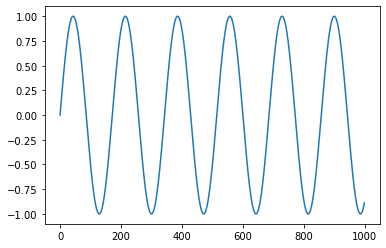

In [8]:
index = 54
t = 1000
plt.plot(train_sequences[index, :t, 0])
plt.show()

In [9]:
display.Audio(train_sequences[index, :, 0], rate=44100)

### Companding transform

In [10]:
def companding_transform(sequences, quantize_channel=256):
  mu = quantize_channel - 1
  epsilon = 1e-10
  safe_abs = np.minimum(np.abs(sequences), 1.0)
  sequence = np.sign(sequences) * np.log(1. + safe_abs * mu) / np.log(1. + mu)
  
  return sequence

In [11]:
train_sequences = companding_transform(train_sequences)
target_sequences = companding_transform(target_sequences)

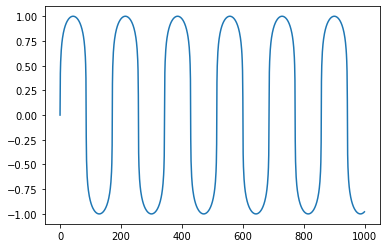

In [12]:
plt.plot(train_sequences[index, :t, 0])
plt.show()

In [13]:
def quantize_inputs(sequences, quantize_channel=256):
  mu = quantize_channel - 1
  #sequences = companding_transform(sequences)
  return np.int32((sequences + 1.) / 2. * mu + 0.5)

In [14]:
train_sequences = quantize_inputs(train_sequences)
target_sequences = quantize_inputs(target_sequences)

In [15]:
def recover_input_scale(sequences, quantize_channel=256):
  # this function is borrowed from https://github.com/ibab/tensorflow-wavenet
  mu = quantize_channel - 1
  # scale to [-1, 1]
  sequences = 2. * (np.float32(sequences) / mu) - 1.
  magnitudes = (1. / mu) * ((1. + mu)**abs(sequences) - 1.)
  return np.sign(sequences) * magnitudes

## Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [16]:
def to_float(sequence, target):
  return tf.dtypes.cast(sequence, tf.float32), target

In [17]:
def one_hot(sequence, target):
  return sequence, tf.one_hot(tf.squeeze(target, axis=-1), 256)

In [18]:
#tf.random.set_seed(219)

# for train
N = len(train_sequences)
train_dataset = tf.data.Dataset.from_tensor_slices((train_sequences, target_sequences))
train_dataset = train_dataset.map(to_float)
train_dataset = train_dataset.map(one_hot)
train_dataset = train_dataset.shuffle(buffer_size=N)
train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=True)
print(train_dataset)

<BatchDataset shapes: ((1, 44100, 1), (1, 44100, 256)), types: (tf.float32, tf.float32)>


## Create the generator and discriminator models

In [19]:
class ResBlock(tf.keras.Model):
  def __init__(self, filters, kernel_size, dilation_rate):
    super(ResBlock, self).__init__()
    """Initiailize learnable parameters.
    """
    self.conv_f = layers.Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='tanh')
    self.conv_g = layers.Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='sigmoid')
    self.conv1x1 = layers.Conv1D(filters, 1, padding='same')
      
  def call(self, inputs):
    f = self.conv_f(inputs)
    g = self.conv_g(inputs)
    z = f * g
    z = self.conv1x1(z)
    outputs = z + inputs
    
    return outputs, z

In [20]:
class StackedResBlock(tf.keras.Model):
  def __init__(self, filters, kernel_size):
    super(StackedResBlock, self).__init__()
    """Initiailize learnable parameters.
    """
    self.block1 = ResBlock(filters, kernel_size, 1)
    self.block2 = ResBlock(filters, kernel_size, 2)
    self.block3 = ResBlock(filters, kernel_size, 4)
    self.block4 = ResBlock(filters, kernel_size, 8)
    self.block5 = ResBlock(filters, kernel_size, 16)
    #self.block6 = ResBlock(filters, kernel_size, 32)
    #self.block7 = ResBlock(filters, kernel_size, 64)
    #self.block8 = ResBlock(filters, kernel_size, 128)
    #self.block9 = ResBlock(filters, kernel_size, 256)
    #self.block10 = ResBlock(filters, kernel_size, 512)
      
  def call(self, inputs):
    x, z1 = self.block1(inputs)
    x, z2 = self.block2(x)
    x, z3 = self.block3(x)
    x, z4 = self.block4(x)
    x, z5 = self.block5(x)
    #x, z6 = self.block6(x)
    #x, z7 = self.block7(x)
    #x, z8 = self.block8(x)
    #x, z9 = self.block9(x)
    #x, z10 = self.block10(x)
    
    z = z1 + z2 + z3 + z4 + z5# +\
        #z6 + z7 + z8 + z9 + z10
    
    return x, z

In [25]:
class WaveNet(tf.keras.Model):
  def __init__(self, filters, kernel_size):
    super(WaveNet, self).__init__()
    """Initiailize learnable parameters.
    """
    #self.conv = layers.Conv1D(filters, kernel_size, padding='causal')
    self.block1 = StackedResBlock(filters, kernel_size)
    self.block2 = StackedResBlock(filters, kernel_size)
    self.block3 = StackedResBlock(filters, kernel_size)
    self.conv1x1_a = layers.Conv1D(filters, 1, padding='same', activation='relu')
    self.conv1x1_b = layers.Conv1D(256, 1, padding='same')#, activation='softmax')

  def call(self, inputs):
    x, z1 = self.block1(inputs)
    x, z2 = self.block2(x)
    x, z3 = self.block3(x)
    
    outputs = tf.nn.relu(z1 + z2 + z3)
    outputs = self.conv1x1_a(outputs)
    outputs = self.conv1x1_b(outputs)
    
    return outputs
  
  def generate(self):
    pass

In [26]:
wavenet = WaveNet(32, 3)

In [27]:
for sequences, targets in train_dataset.take(1):
  outputs = wavenet(sequences)

In [28]:
outputs.shape

TensorShape([1, 44100, 256])

## Define the loss functions and the optimizer

* Actually we use the log likelihood function as loss function

### Define loss function

In [29]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

### Define optimizer

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate)

## Checkpoints (Object-based saving)

In [31]:
checkpoint_dir = train_dir
if not tf.io.gfile.exists(checkpoint_dir):
  tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, nade=wavenet)

## Training

### Define training one step function

In [32]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(sequences, targets):
  with tf.GradientTape() as tape:
    predictions = wavenet(sequences)
    loss_value = loss_object(targets, predictions)
      
  gradients = tape.gradient(loss_value, wavenet.trainable_variables)
  optimizer.apply_gradients(zip(gradients, wavenet.trainable_variables))

  return loss_value

### Training full steps

In [33]:
print('Start Training.')
num_batches_per_epoch = int(N / batch_size)
global_step = tf.Variable(0, trainable=False)

for epoch in range(max_epochs):
  
  for step, (sequences, targets) in enumerate(train_dataset):
    start_time = time.time()

    loss = train_step(sequences, targets)
    global_step.assign_add(1)
    
    if global_step.numpy() % print_steps == 0:
      epochs = epoch + step / float(num_batches_per_epoch)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      display.clear_output(wait=True)
      print("Epochs: {:.2f} global_step: {} loss: {:.3g} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, global_step.numpy(), loss.numpy(), examples_per_sec, duration))
      #sample_images = nade.sampling(num_examples_to_generate)
      #print_or_save_sample_images(sample_images.numpy(), num_examples_to_generate)
      
#   if (epoch + 1) % save_images_epochs == 0:
#     display.clear_output(wait=True)
#     print("This images are saved at {} epoch".format(epoch+1))
#     sample_images = nade.sampling(num_examples_to_generate)
#     print_or_save_sample_images(sample_images.numpy(), num_examples_to_generate,
#                                 is_square=True, is_save=True, epoch=epoch+1,
#                                 checkpoint_dir=checkpoint_dir)
      
  # saving (checkpoint) the model every save_epochs
  if (epoch + 1) % save_model_epochs == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)
    
print('Training Done.')

Epochs: 9.11 global_step: 912 loss: 2.55 (40.75 examples/sec; 0.025 sec/batch)


KeyboardInterrupt: 

In [34]:
# generating after the final epoch
display.clear_output(wait=True)

## Restore the latest checkpoint

In [35]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Display an image using the epoch number

In [36]:
display_image(max_epochs, checkpoint_dir=checkpoint_dir)

FileNotFoundError: [Errno 2] No such file or directory: 'train/wavenet/exp1/image_at_epoch_0010.png'

## Generate a GIF of all the saved images.

In [37]:
filename = model_name + '_' + dataset_name + '.gif'
generate_gif(filename, checkpoint_dir)

UnboundLocalError: local variable 'filename' referenced before assignment

In [ ]:
display.Image(filename=filename + '.png')